<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 7
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

Cuando tomamos una o varias muestras de una senal, como por ejemplo en un electrocardiograma, podemos observar que el espectro de cada muestra es diferente, esto es asi ya que la FFT funciona como un estimador. Vamos a comparar resultados de diferentes estimadores vistos en la teoria.

Para esto, vamos a trabajar con la potencia espectral como estimador, para finalmente, tratar de estimar el Ancho de banda de la senal medida

Vamos a utilizar una senal de audio para esto

In [53]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from bartlett_periodogram import *
import scipy.io as sio
from scipy.io.wavfile import write
import tkinter as tk
from tkinter import filedialog
import sounddevice as sd
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')

In [54]:
def bartlett_periodogram(x, fs, segment_size):
    """
    Calcula el periodograma de Bartlett para una señal x.

    Parámetros:
    - x: Señal de entrada (1D)
    - fs: Frecuencia de muestreo
    - segment_size: Tamaño de cada segmento
    
    Retorna:
    - f: Vector de frecuencias
    - Pxx: PSD estimada
    """
    # Número de segmentos
    num_segments = len(x) // segment_size

    # Inicializamos el acumulador de PSD
    Pxx = np.zeros(segment_size)

    # Calculamos el periodograma para cada segmento
    for i in range(num_segments):
        segment = x[i * segment_size:(i + 1) * segment_size]
        X = np.fft.fft(segment)  # FFT del segmento
        Pxx_segment = (np.abs(X[:segment_size]) ** 2) / segment_size  # PSD del segmento
        Pxx += Pxx_segment  # Acumulamos la PSD

    # Promediamos la PSD sobre los segmentos
    Pxx /= num_segments

    # Frecuencias correspondientes
    f = np.fft.fftfreq(segment_size, d=1/fs)[:segment_size]

    return f, Pxx

In [55]:
def create_audio_player(parent, audio_data, fs, title="Audio"):
    """
    Crea un reproductor de audio dentro de un contenedor padre.
    
    Parámetros:
        parent: tk.Widget
            El contenedor (ventana o marco) donde se ubicará el reproductor.
        audio_data: numpy.ndarray
            Señal de audio a reproducir.
        fs: int
            Frecuencia de muestreo de la señal de audio.
        title: str
            Título del reproductor.
    """
    # Crear un marco para el reproductor
    frame = tk.Frame(parent, borderwidth=2, relief="groove")
    frame.pack(pady=5, padx=10, fill="x")

    # Etiqueta de título
    label_title = tk.Label(frame, text=title, font=("Arial", 12, "bold"))
    label_title.pack(pady=5)

    # Botón para reproducir el audio
    def play_audio():
        try:
            sd.play(audio_data, samplerate=fs)  # Reproducir la señal
            label_status.config(text="Reproduciendo...", fg="green")
            sd.wait()  # Esperar a que termine la reproducción
            label_status.config(text="Listo", fg="blue")
        except Exception as e:
            label_status.config(text=f"Error: {e}", fg="red")
    
    button_play = tk.Button(frame, text="Reproducir", command=play_audio, bg="blue", fg="white", font=("Arial", 10))
    button_play.pack(pady=5)

    # Etiqueta para el estado
    label_status = tk.Label(frame, text="Listo", font=("Arial", 10), fg="blue")
    label_status.pack(pady=5)

In [56]:
def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

Primero vamos a extraer la senal y realizar un periodograma para estimar la potencia espectral


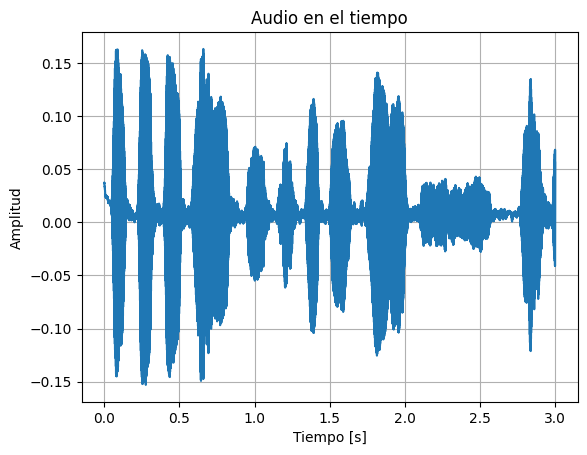

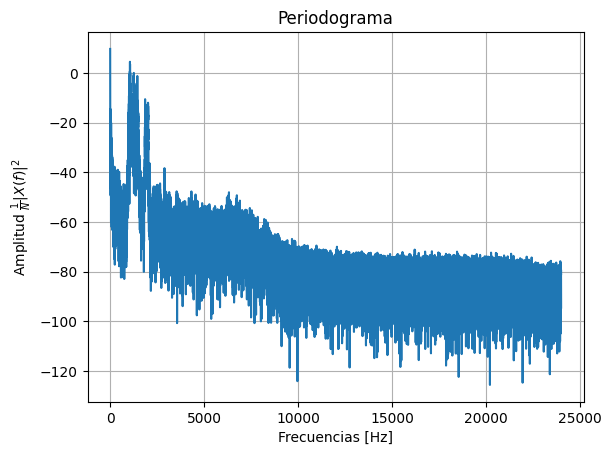

In [57]:
## Extraemos la senal de audio del archivo

fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav')

## Realicemos un periodogrma de la senal

N = len(wav_data)
freqs = np.fft.fftfreq(N,d= 1/fs_audio)

t = np.linspace(0, N/fs_audio, N )
plt.figure(1)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Audio en el tiempo")
plt.plot(t,wav_data)
plt.grid()
plt.show()

fft_audio = np.fft.fft(wav_data)
per_audio = np.abs(fft_audio)**2/N

plt.figure(2)
plt.title("Periodograma")
plt.xlabel("Frecuencias [Hz]")
plt.ylabel(r"Amplitud $ \frac{1}{N} |X(f)|^{2} $")  ## Revisar LaTex
plt.plot(freqs[:N//2],10*np.log10(per_audio[:N//2]))
plt.grid()
plt.show()


Ahora vamos a agregar un ventaneo a la senal, usando una ventana de Blackman

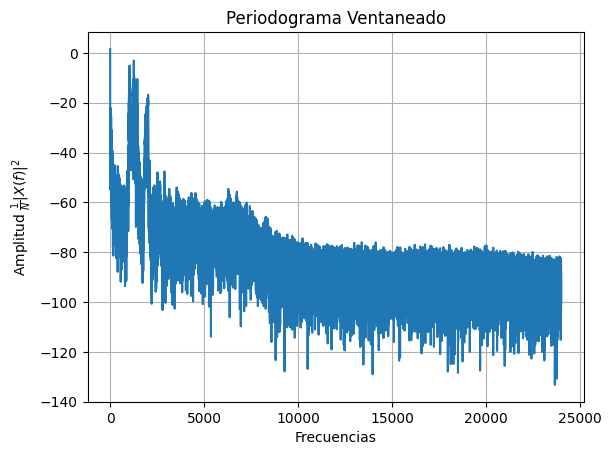

In [58]:
## Procedemos a realizar un Periodograma ventaneado

window_blackman = np.blackman(N)
fft_audio_per_vent = np.fft.fft(wav_data*window_blackman)
per_vent_audio = np.abs(fft_audio_per_vent)**2/N

plt.figure(3)
plt.title("Periodograma Ventaneado")
plt.xlabel("Frecuencias")
plt.ylabel(r"Amplitud $\frac{1}{N}|X(f)|^{2}$")  ## Revisar LaTex
plt.plot(freqs[:N//2],10*np.log10(per_vent_audio[:N//2]))
plt.grid()
plt.show()

Ahora, vamos a realizar una estimacion por metodo de Bartlett, que consiste en subdivir la muestra en varios segmentos, calcular el periodograma de cada uno y promediar

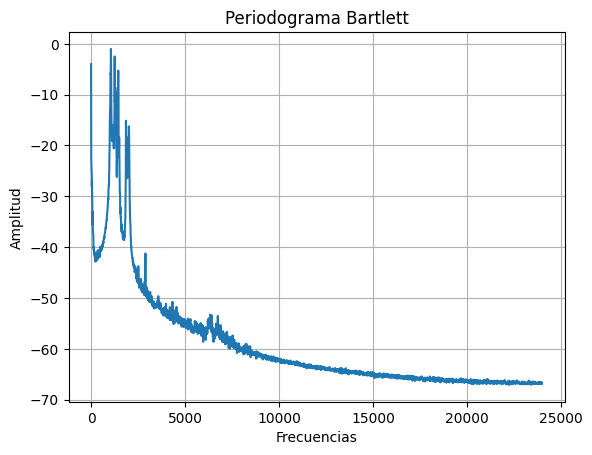

In [59]:
## Metodo de Bartlett

segment_size = int(N/24)
[freqs_bartlett, fft_bartlett] = bartlett_periodogram(wav_data, fs_audio, segment_size)
N_bartlett = len(freqs_bartlett)

plt.figure(4)
plt.title("Periodograma Bartlett")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_bartlett[:N_bartlett//2],10*np.log10(fft_bartlett[:N_bartlett//2]))
plt.grid()
plt.show()

Podemos ver como se reduce  la varianza en cada frecuencia, viendo ese suavizado en la FFT. Hay que ser consciente de que este metodo empeora la resolucion, tienendo que elegir entre varianza y resolucion

Por ultimo, vamos a utilizar el metodo de Welch. El mismo requiere armar diferentes bloques a partir de una muestra, las mismas pueden estar solapadas ya que se pueden considerar  de diferentes muestras si el proceso es estacionario en sentido amplio. A su vez, cada muestra se ventanea, lo que ayuda a reducir el sesgo

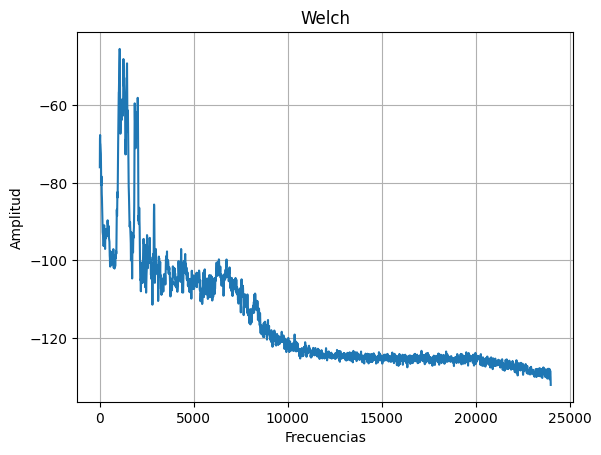

In [60]:
w=24  ## Numero de ventanas 
[freqs_welch, fft_welch] = sc.signal.welch(wav_data, fs_audio, window = "hann", nperseg = int(N/w))

plt.figure(5)
plt.title("Welch")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_welch,10*np.log10(fft_welch))
plt.grid()
plt.show()

 ## Calculo del ancho de banda

 Vamos a buscar estimar el ancho de banda de la senal, tomando cierto porcentaje de la potencia de la senal a partir de nuestra estimacion de potencia

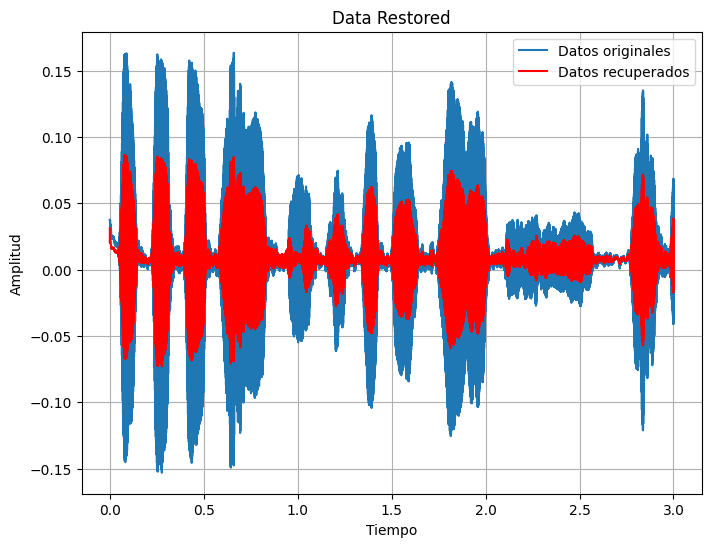

El ancho de banda de la senal de audio es de: 1976.00 Hz


In [61]:
## Tomamos el BW a partir de Welch

BW_total_pow = 0.98
sumatoria = 0

per_norm = fft_welch/np.sum(np.abs(fft_welch))

for i in range(0,len(fft_welch)):
    sumatoria += np.abs(per_norm[i])
    index_bw = i
    if sumatoria >= BW_total_pow:
        break

BW = freqs_welch[i]
fft_filter = np.zeros_like(fft_audio)
fft_filter[:index_bw*w] = fft_audio[:w*index_bw] ## w para reajustar lo que se achico el indice en welch

wav_data_restored =np.fft.ifft(fft_filter)       ## No es el mejor porque transformo el brickwall

plt.figure(6, figsize=(8,6))
plt.title("Data Restored")
plt.xlabel("Tiempo")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(t, wav_data,label = "Datos originales")
plt.plot(t,wav_data_restored, color = "red", label = "Datos recuperados")
plt.legend()
plt.grid()
plt.show()

print(f"El ancho de banda de la senal de audio es de: {BW:.2f} Hz")

Vamos a reproducir el audio para poder comparar

In [62]:
## Audio de la senal original
#sd.play(wav_data,fs_audio)

# Crear la ventana principal
root = tk.Tk()
root.title("Múltiples Reproductores de Audio")
root.geometry("400x400")

create_audio_player(root,wav_data,fs_audio,"Senal original")
create_audio_player(root,np.abs(wav_data_restored),fs_audio,"Senal restaurada")

root.mainloop()

# Senal ECG

Ahora vamos a bucar calcular el ancho de banda de la senal de ECG


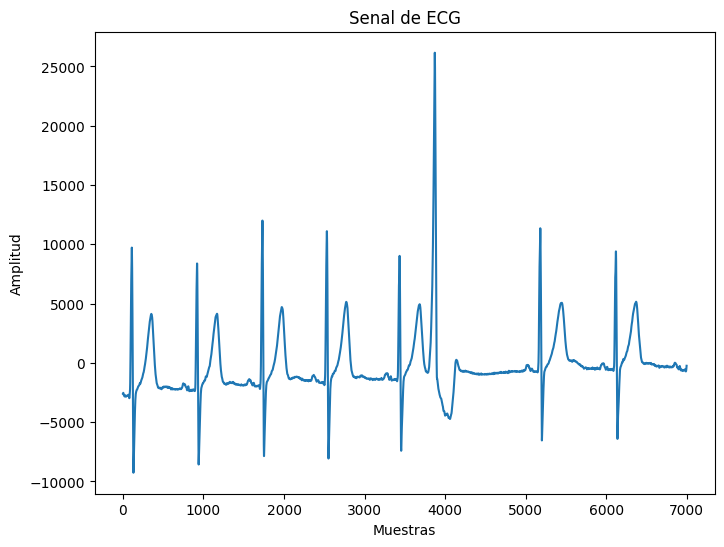

In [78]:
fs_ecg = 1000
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)
t = np.arange(0,10, 1/fs_ecg)

plt.figure(7, figsize=(8,6))
plt.title("Senal de ECG")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.plot(ecg_one_lead[5000:12000])
plt.show()

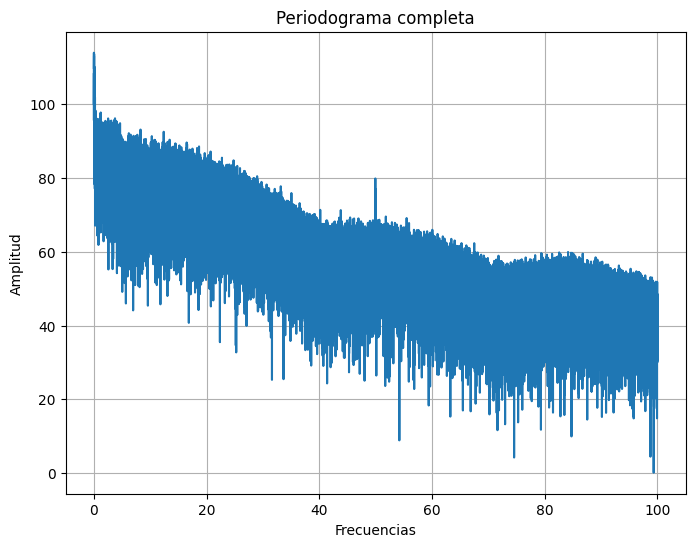

In [79]:
## Peridograma simple de la senal completa
freqs_full = np.fft.fftfreq(len(ecg_one_lead), d=1/fs_ecg)
fft_ecg_full = np.fft.fft(ecg_one_lead)
Pxx_ecg_full = np.abs(fft_ecg_full)**2/N
i = int(len(freqs_full)/2)
bool_index = (freqs_full >= 0) & (freqs_full <= 100)

plt.figure(8, figsize=(8,6))
plt.title("Periodograma completa")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_full[bool_index],10*np.log10(Pxx_ecg_full)[bool_index])
plt.grid()
plt.show()

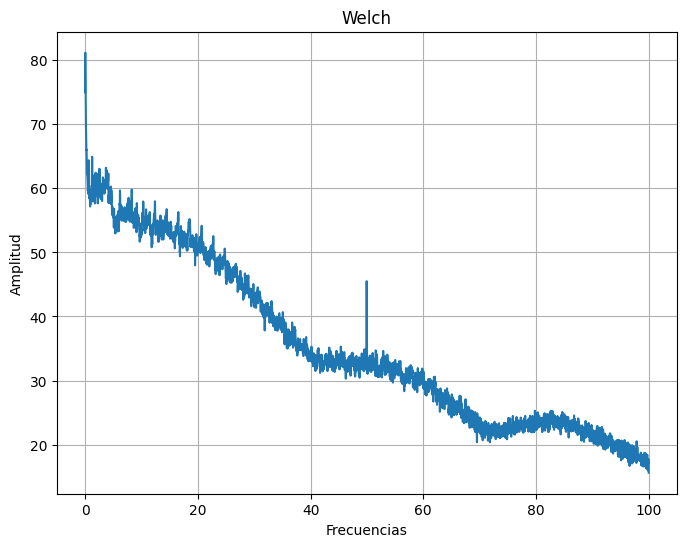

In [80]:
## Welch de la senal
w = 24
[freqs_welch, fft_welch] = sc.signal.welch(ecg_one_lead, fs_ecg, window = "hann", nperseg = int(N/w), detrend ="linear") ## Detrend saca la pendiente
bool_index = (freqs_welch >= 0) & (freqs_welch <= 100)

plt.figure(9, figsize=(8,6))
plt.title("Welch")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_welch[bool_index],10*np.log10(fft_welch)[bool_index])
plt.grid()
plt.show()

Podemos apreciar como el Welch reduce la varianza fuertemente y nos permite identificar fenomenos que con el periodograma comun no podriamos, como el ruido en 50 Hz, probablemente de la linea de alimentacion.

Vamos a buscar estimar el ancho de banda de esta senal

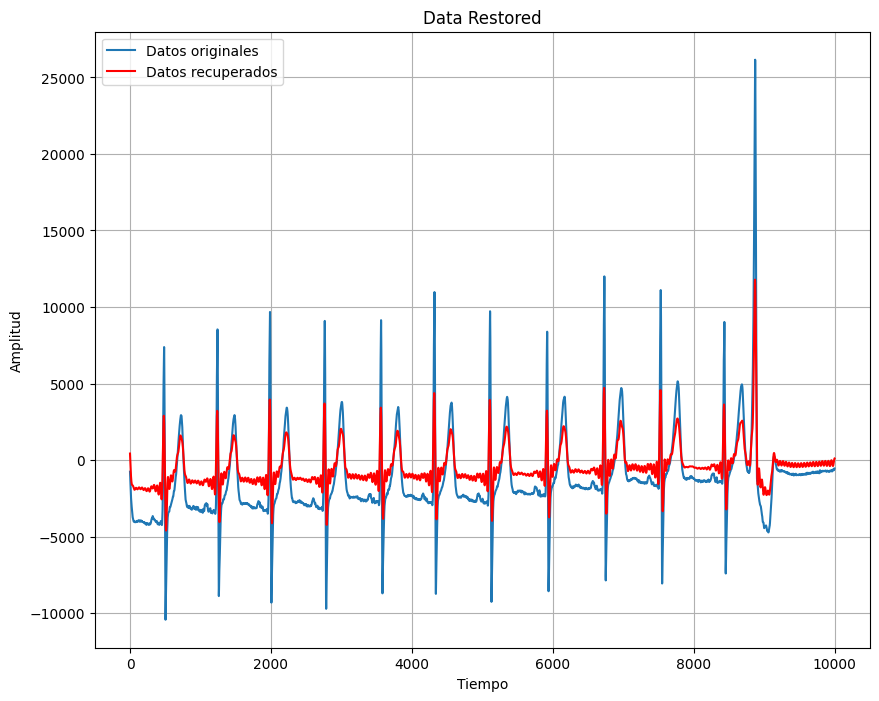

El ancho de banda de la senal ECG es de: 23.36 Hz


In [83]:
## Tomamos el BW a partir de Welch

BW_total_pow = 0.98
sumatoria = 0

per_norm = fft_welch/np.sum(np.abs(fft_welch))

for i_ecg in range(0,len(fft_welch)):
    sumatoria += np.abs(per_norm[i_ecg])
    index_bw_ecg = i_ecg
    if sumatoria >= BW_total_pow:
        break

BW = freqs_welch[i_ecg]
fft_filter = np.zeros_like(fft_ecg_full)
fft_filter[0:index_bw_ecg*w] = fft_ecg_full[0:w*index_bw_ecg] ## w para reajustar lo que se achico el indice en welch
#index = (freqs_welch <= 2*np.pi*50/fs_ecg)

ecg_restored = np.fft.ifft(fft_filter).real       ## No es el mejor porque transformo el brickwall

plt.figure(10, figsize=(10,8))
plt.title("Data Restored")
plt.xlabel("Tiempo")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(ecg_one_lead[0:10000],label = "Datos originales")
plt.plot(ecg_restored[0:10000], color = "red", label = "Datos recuperados")
plt.legend()
plt.grid()
plt.show()

print(f"El ancho de banda de la senal ECG es de: {BW:.2f} Hz")

# Senal PPG

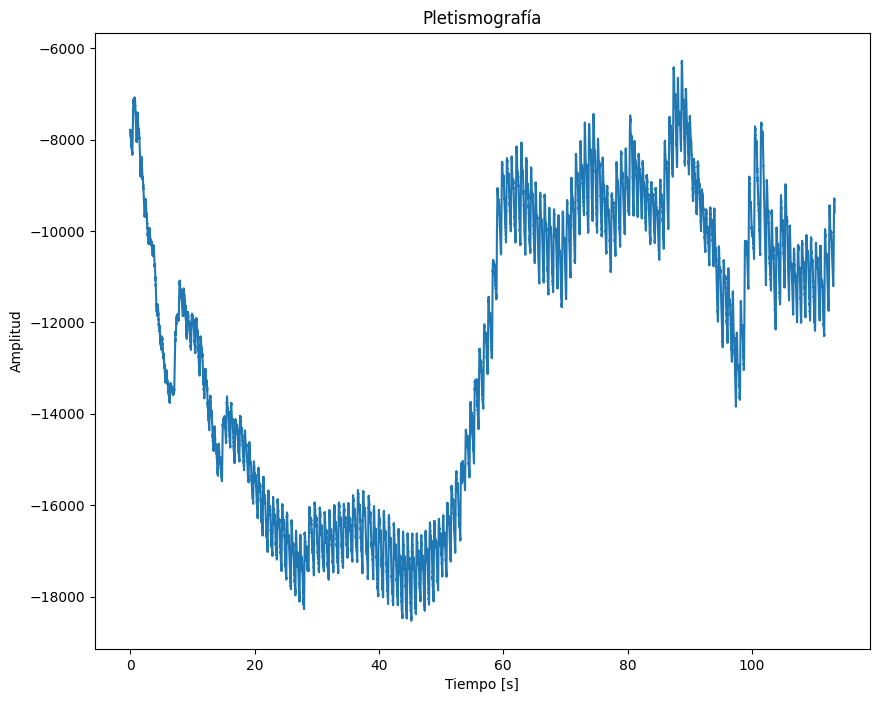

In [84]:
fs_ppg = 400 # Hz

# Cargar el archivo CSV como un array de NumPy
ppg = np.genfromtxt('./PPG.csv', delimiter=',', skip_header=1)  # Omitir la cabecera si existe

N = len(ppg)
t = np.arange(0,N/fs_ppg,1/fs_ppg)

plt.figure(11, figsize=(10,8))
plt.title("Pletismografía")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo [s]")
plt.plot(t,ppg)
plt.show()

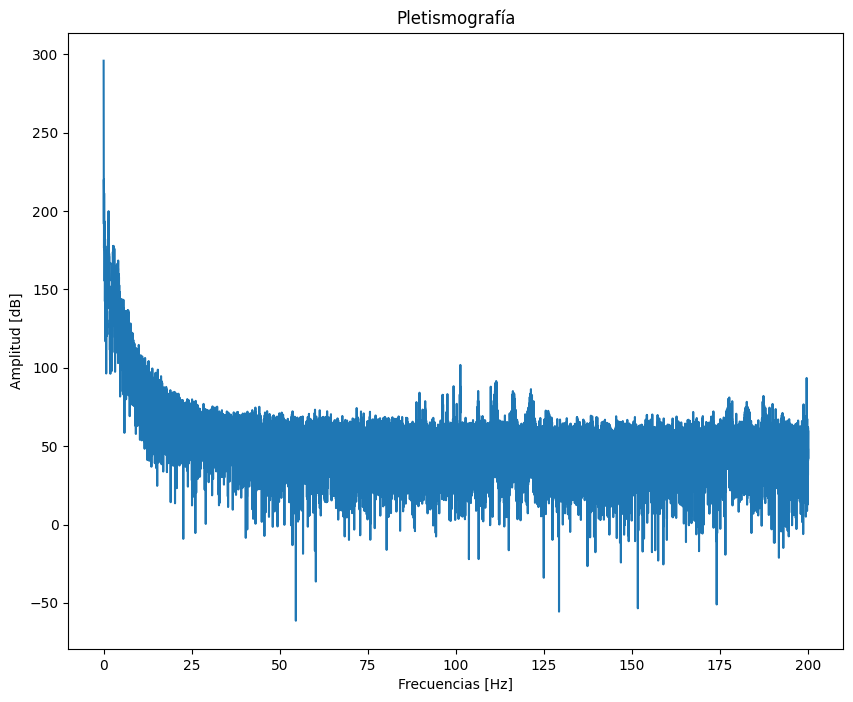

In [85]:
## Realizamos un Periodograma de la senal

fft_ppg = np.fft.fft(ppg)
freqs_ppg = np.fft.fftfreq(N,1/fs_ppg)
per_ppg = np.abs(fft_ppg)**2/N
index_bool = (freqs_ppg >= 0) #& (freqs_ppg <= 200)

plt.figure(12, figsize=(10,8))
plt.title("Pletismografía")
plt.ylabel("Amplitud [dB]")
plt.xlabel("Frecuencias [Hz]")
plt.plot(freqs_ppg[index_bool],10*np.log(per_ppg[index_bool]))
plt.show()

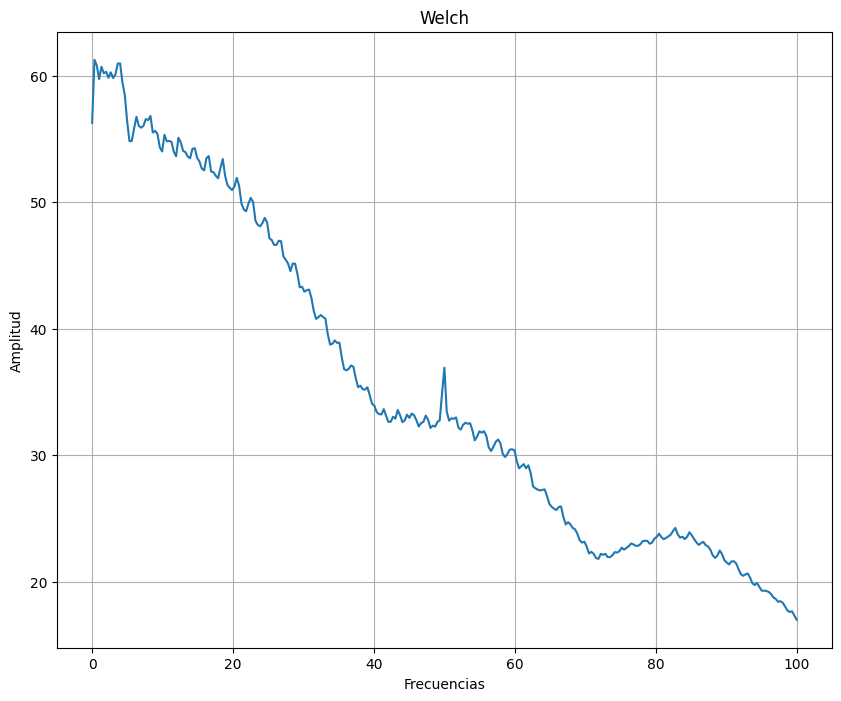

Se tomaron 15 ventanas y se obtuvo una resolucion en frecuencia de  0.1324 Hz


In [86]:
## Welch de la senal
w = 15
[freqs_welch, fft_welch] = sc.signal.welch(ecg_one_lead, fs_ecg, window = "hann", nperseg = int(N/w), detrend ="linear") ## Detrend saca la pendiente
bool_index = (freqs_welch >= 0) & (freqs_welch <= 100)

plt.figure(13, figsize=(10,8))
plt.title("Welch")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_welch[bool_index],10*np.log10(fft_welch)[bool_index])
plt.grid()
plt.show()

print(f"Se tomaron {w} ventanas y se obtuvo una resolucion en frecuencia de {w*fs_ppg/N: .4f} Hz")

## Ancho de banda del PPG

Vamos a calcular el BW del PPG con el mismo metodo tomando el Welch, ya que volvimos a observar como disminuye el ruido en amplitud de la senal

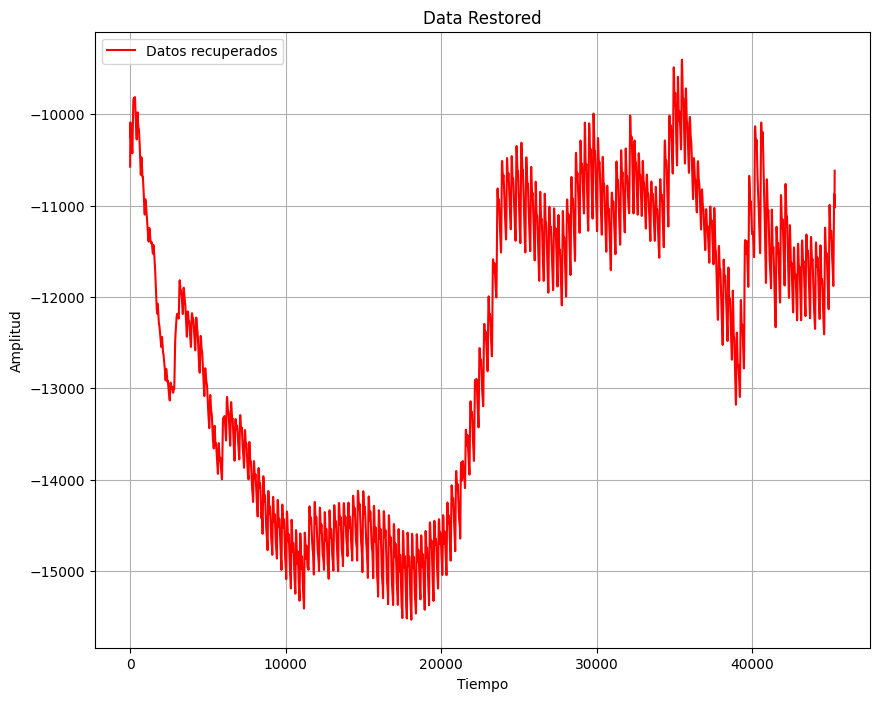

El ancho de banda de la senal ECG es de: 27.47 Hz.
De esta forma eliminamos la interferencia de 50 Hz que se ve en el grafico


In [90]:
## Tomamos el BW a partir de Welch

BW_total_pow = 0.98
sumatoria = 0

per_norm = fft_welch/np.sum(np.abs(fft_welch))

for i_ppg in range(0,len(fft_welch)):
    sumatoria += np.abs(per_norm[i_ppg])
    index_bw_ppg = i_ppg
    if sumatoria >= BW_total_pow:
        break

BW = freqs_welch[i_ppg]
fft_filter = np.zeros_like(fft_ppg)
fft_filter[0:index_bw_ppg*w] = fft_ppg[0:w*index_bw_ppg] ## w para reajustar lo que se achico el indice en welch
#index = (freqs_welch <= 2*np.pi*50/fs_ecg)

ppg_restored = np.fft.ifft(fft_filter).real       ## No es el mejor porque transformo el brickwall

plt.figure(10, figsize=(10,8))
plt.title("Data Restored")
plt.xlabel("Tiempo")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
#plt.plot(ecg_one_lead[0:len(t)],label = "Datos originales")
plt.plot(ppg_restored, color = "red", label = "Datos recuperados")
plt.legend()
plt.grid()
plt.show()

print(f"El ancho de banda de la senal ECG es de: {BW:.2f} Hz.\nDe esta forma eliminamos la interferencia de 50 Hz que se ve en el grafico")

# Coclusion

Pudimos comparar diferentes metodos de estimacion espectral, que si bien un periodograma es una buena primer estimacion,
podemos optar por metodos mas sofisticados como un periodograma ventaneada o un Welch, que mejoran la resolucion de la amplitud, o mejor dicho,
mejoran la varianza de la amplitud. 

Como punto en contra de Welch, reduce la resolucion en frecuencia proporcionalmente al numero de ventanas,
pero como muchas veces la frecuencia de muestreo es mucho mayor al ancho de banda de la senal, no suele representar un problema, pero con cuidado
de no perder variaciones en la amplitud dentro de esta resolucion